In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams["figure.figsize"] = 8, 5
from statsmodels.tsa import arima_model

from sklearn.linear_model import LinearRegression

from importlib import reload
import os

import funcs

funcs = reload(funcs)

In [2]:
train_data = pd.read_csv(os.path.join('data', 'ts_train.csv'))
test_data = pd.read_csv('data/ts_test.csv')

In [3]:
train_data.head()

,ID,Date,tsID,ACTUAL,Temp,Saturday,Sunday
0,15672,01.01.2010,1,90468.0,22.5,0.0,1
1,15673,02.01.2010,1,92764.0,20.0,1.0,0
2,15674,03.01.2010,1,94791.0,21.0,0.0,1
3,15675,04.01.2010,1,98010.0,16.8,0.0,1
4,15676,05.01.2010,1,100975.0,19.2,0.0,1


### train, validation and test

Keep validation size roughly equalt to test size to get more realistic results.

In [4]:
train_size = 0.6
valid_size = 0.4 # ~

indices = np.arange(len(train_data))

train = []
valid = []

for i in train_data.tsID.unique():
    indices = np.where(train_data.tsID == i)[0]
    size = int(len(indices) * train_size)
    
    train.append(train_data.iloc[indices][:size].copy())
    valid.append(train_data.iloc[indices][size:].copy())
    
train = pd.concat(train)
valid = pd.concat(valid)

In [5]:
train.shape, valid.shape

((8360, 7), (5588, 7))

In [6]:
def select_ts(index):
    return (train_data[train_data.tsID == index].copy(),
            test_data[test_data.tsID == index].copy())

In [7]:
def ses_smooth(time_series, alpha):
    assert 0 < alpha < 1
    
    p_sum = time_series[0]
    for datum in time_series:
        p_sum = alpha * datum + (1 - alpha) * p_sum
        yield p_sum

In [8]:
smooth_train = []

for i in train_data.tsID.unique():
    data = pd.DataFrame()
    data['ACTUAL'] = (list(ses_smooth(select_ts(i)[0].ACTUAL.values.copy(), 0.1)))
    data['tsID'] = i
    smooth_train.append(data)
    
smooth_train = pd.concat(smooth_train)

In [9]:
def select_valid(index):
    return (train[train.tsID == index].copy(),
            valid[valid.tsID == index].copy())

def select_test(index):
    return (train_data[train_data.tsID == index].copy(),
            test_data[test_data.tsID == index].copy())

Time series 1


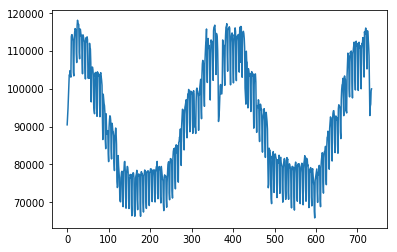

Time series 2


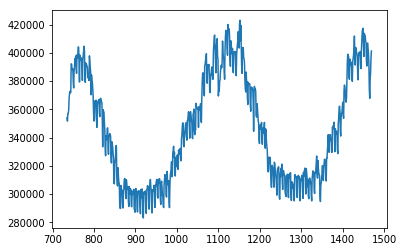

Time series 3


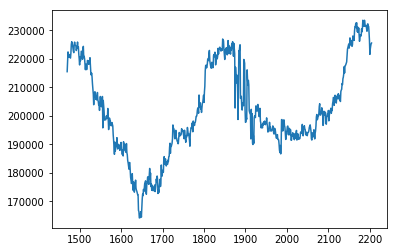

Time series 4


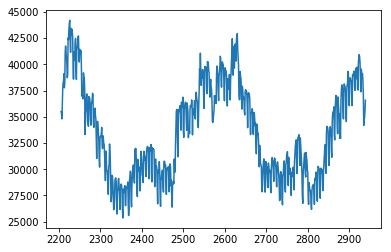

Time series 5


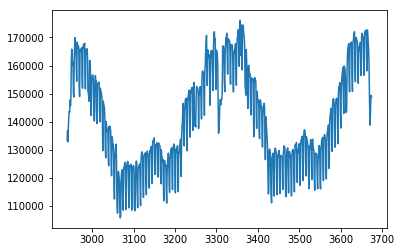

Time series 6


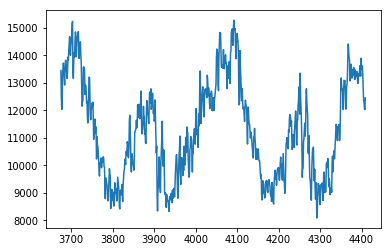

Time series 7


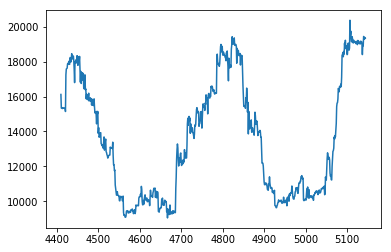

Time series 8


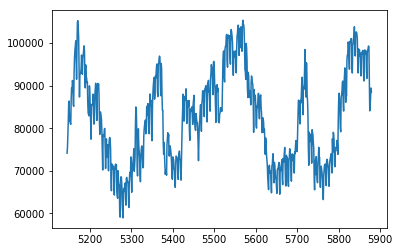

Time series 9


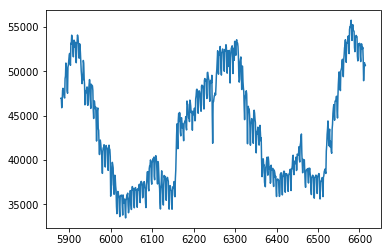

Time series 10


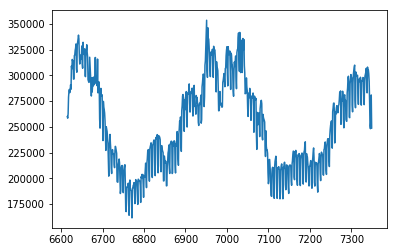

Time series 11


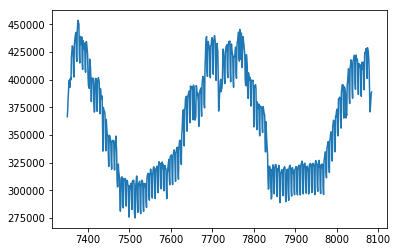

Time series 12


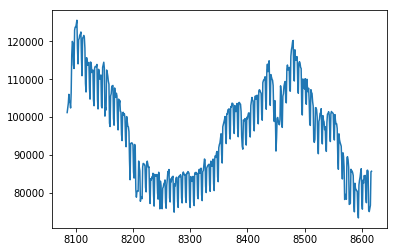

Time series 13


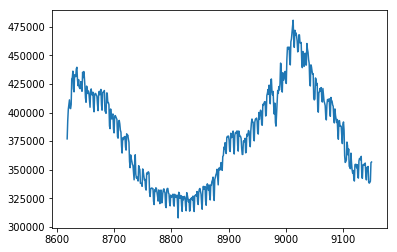

Time series 14


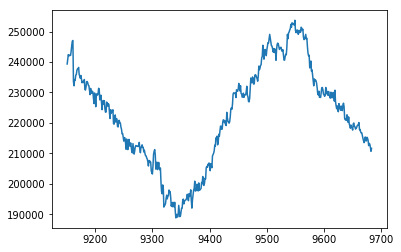

Time series 15


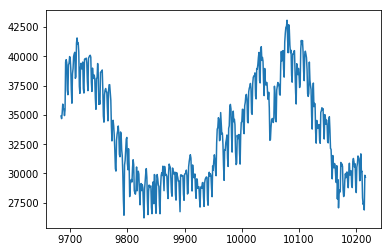

Time series 16


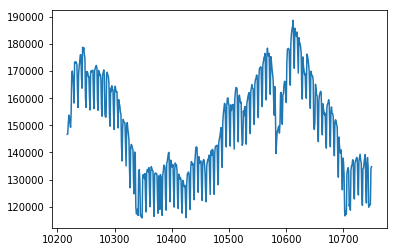

Time series 17


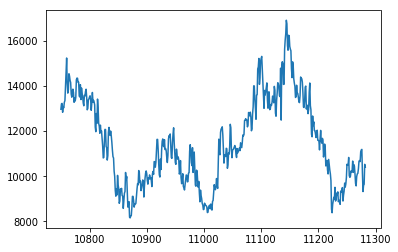

Time series 18


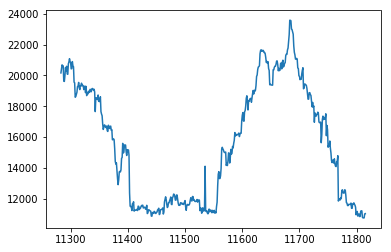

Time series 19


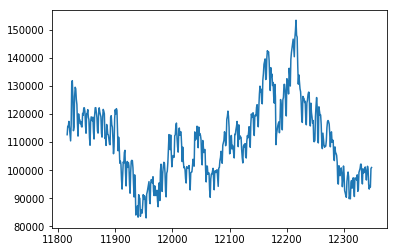

Time series 20


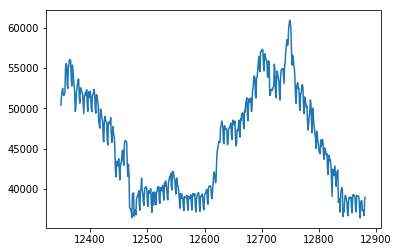

Time series 21


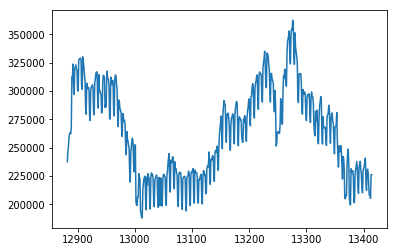

Time series 22


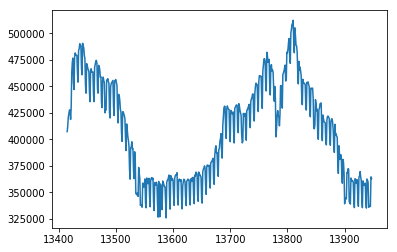

In [10]:
for i in train_data.tsID.unique():
    print(f"Time series {i}")
    plt.plot(select_ts(i)[0].ACTUAL)
    plt.show()

In [11]:
D = 25

In [12]:
def prepare(data):
    train_matrix = []
    test_vector = []
    data = data.ACTUAL.values

    for i in range(D, len(data)):
        train_matrix.append(data[i-D:i])
        test_vector.append(data[i])
    return np.array(train_matrix), np.array(test_vector)

In [163]:
def estimate_linear_reg(train, test):
    M, Y = prepare(train)
    model = LinearRegression()
    model.fit(M, Y)

    x = train.ACTUAL.values[-D:]
    y = []

    for _ in range(len(test)):
        p = model.predict(x.reshape(1, -1))
        y.append(p[0])
        x = np.hstack((x[1:], p))
    test["ACTUAL"] = y
    return test

def estimate(train, test, seas_size, trend):
    y = []
    for i in range(len(test)):
        y.append(train.ACTUAL.values[len(train) - seas_size + i] + trend)
    test["ACTUAL"] = y
    return test

def arima_pred_valid(indices):
    arima_pred = []
    arima_actual = []

    for ts_id in indices:
        tr, te = select_valid(ts_id)
        arima = arima_model.ARIMA(tr.ACTUAL.values, order=(3, 1, 2))
        arima_fit = arima.fit()
        pred = arima_fit.predict(0, len(te))

        arima_pred.append(pred)
        arima_actual.append(val.ACTUAL.values)
    return arima_pred, arima_actual

def arima_pred_test(train, test):
    arima_pred = []

    arima = arima_model.ARIMA(tr.ACTUAL.values, order=(3, 0, 2))
    arima_fit = arima.fit()
    pred = arima_fit.predict(1, len(test))
    
    test["ACTUAL"] = pred
    return test

Define seasonality and trend by looking at the graphs

In [139]:
ts_trends = np.zeros(len(train_data.tsID.unique()))
average_seasonality = 364

ts_trends[[2, 12, 13]] = 10000

In [140]:
def select_trend(i):
    return ts_trends[i - 1]

In [141]:
def validation(indices):
    for i in indices:
        yield estimate(*select_valid(i), average_seasonality, select_trend(i)), select_valid(i)[1]
        
def validation_linear_reg(indices):
    for i in indices:
        yield estimate_linear_reg(*select_valid(i)), select_valid(i)[1]
        
def test(indices, other_indices):
    for i in indices:
        if i in other_indices:
            yield arima_pred_test(*select_test(i))
            continue
        yield estimate(*select_test(i), average_seasonality, select_trend(i))

Time series index 0


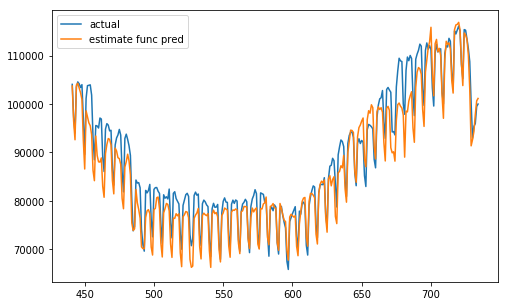

Time series index 1


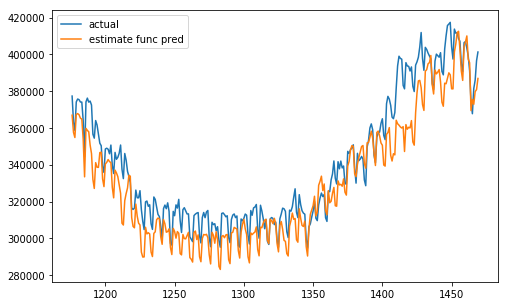

Time series index 2


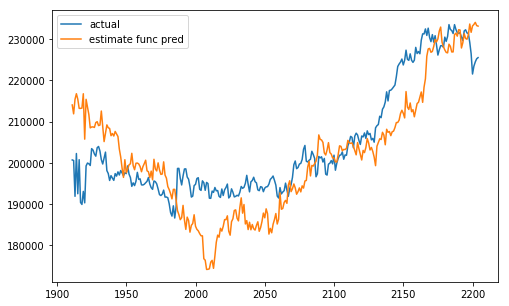

Time series index 3


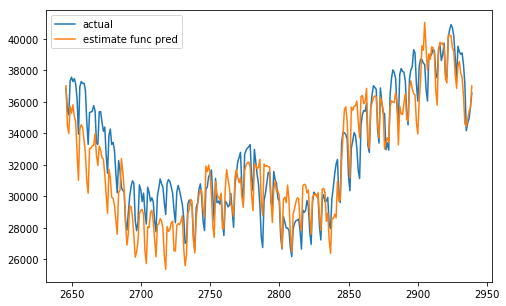

Time series index 4


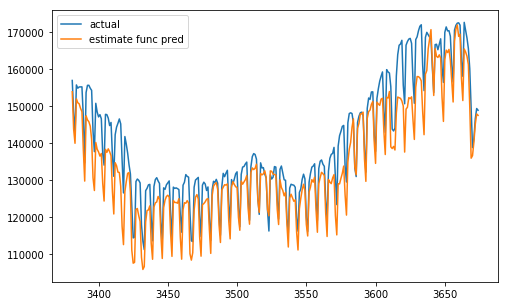

Time series index 5


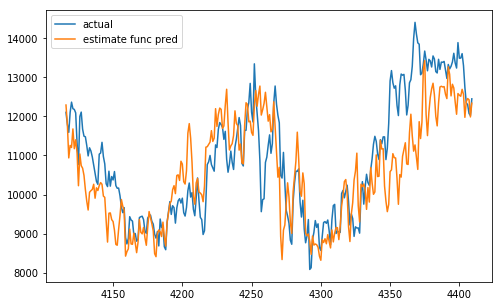

Time series index 6


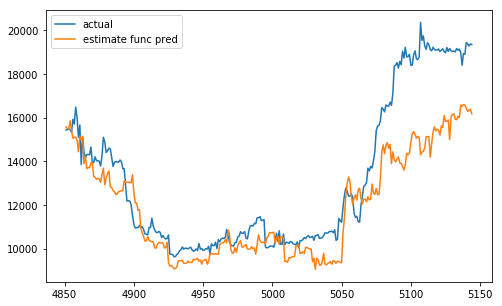

Time series index 7


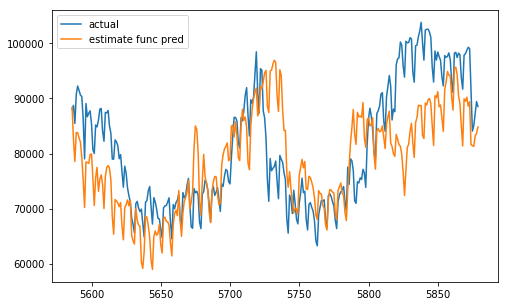

Time series index 8


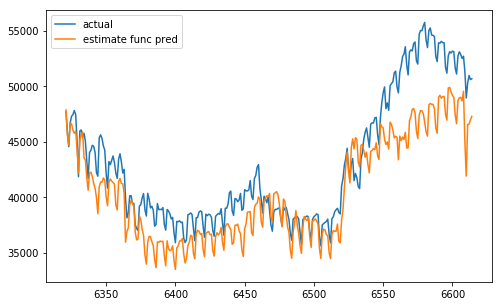

Time series index 9


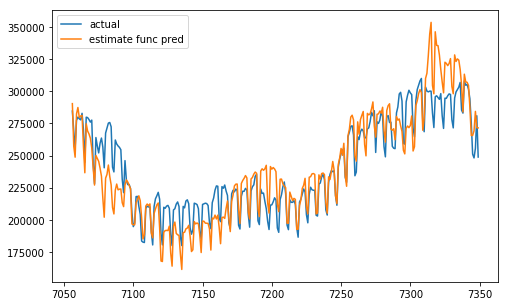

Time series index 10


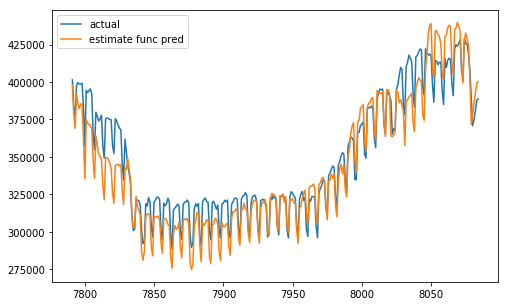

Time series index 11


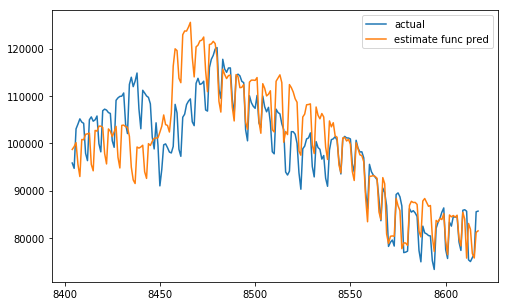

Time series index 12


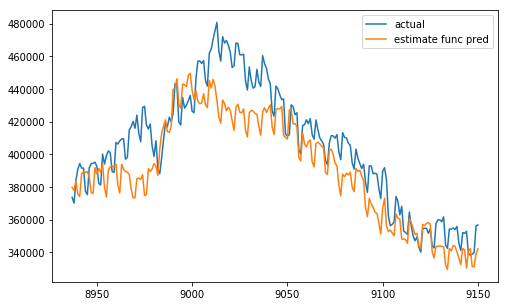

Time series index 13


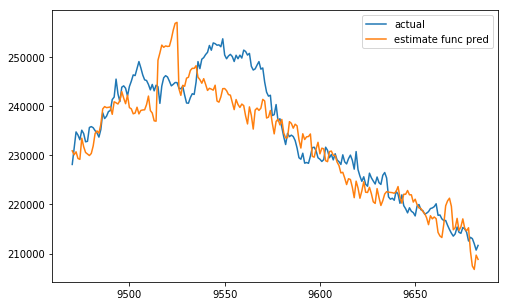

Time series index 14


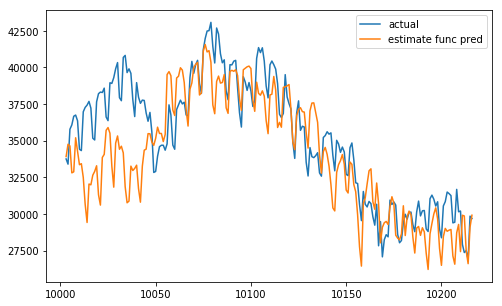

Time series index 15


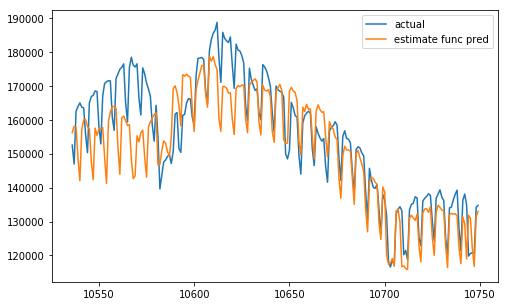

Time series index 16


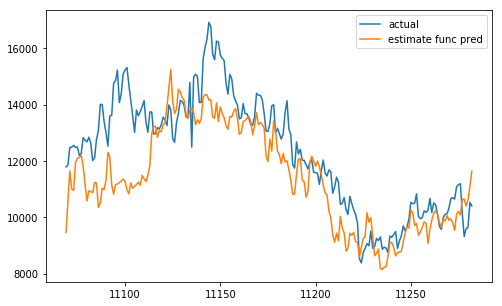

Time series index 17


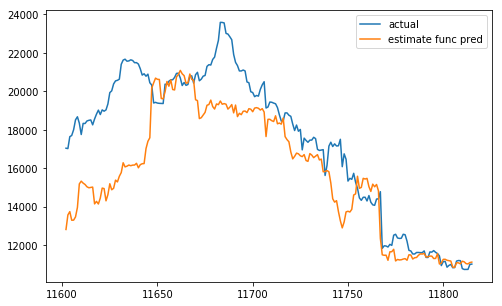

Time series index 18


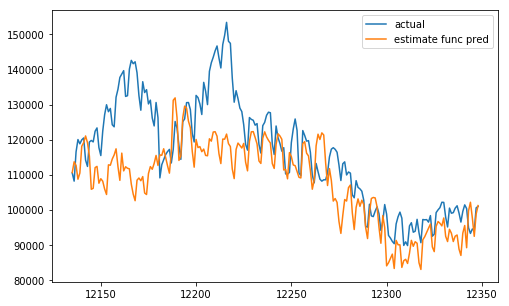

Time series index 19


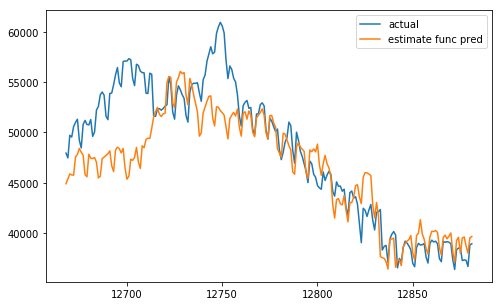

Time series index 20


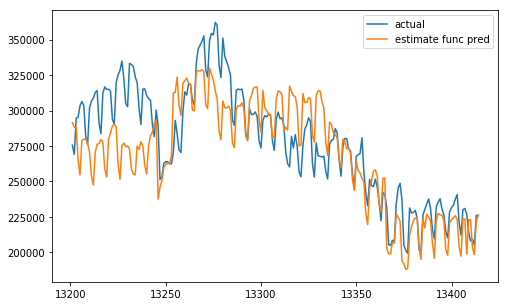

Time series index 21


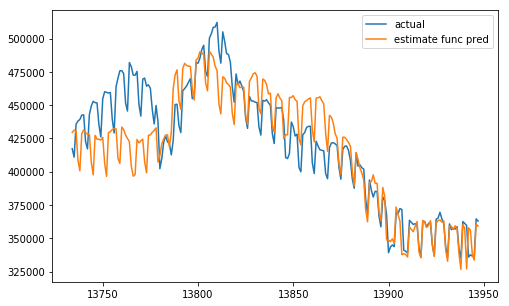

In [131]:
i = 0
for pred, actual in validation(valid.tsID.unique()):
    print(f"Time series index {i}")
    i += 1
    plt.figure(figsize=(8, 5))
    plt.plot(actual.ACTUAL)
    plt.plot(pred.ACTUAL)
    plt.legend(["actual", "estimate func pred"])
    plt.show()

In [89]:
v_pred = []
v_actual = []

for pred, actual in validation(valid.tsID.unique()):
    v_pred.append(pred.ACTUAL.values)
    v_actual.append(actual.ACTUAL.values)

v_pred = np.array(v_pred)
v_actual = np.array(v_actual)

In [90]:
np.mean([funcs.mape(pred, actual) for pred, actual in zip(v_pred, v_actual)])

5.382505506145879

The indices of the time series data that does not seem to have been estimated well in the graph.

In [91]:
bad_time_series_inds = np.array([16, 17, 21])
bad_time_series_tsID = bad_time_series_inds + 1 # tsID starts at 1

In [92]:
inds = np.array([i for i in np.arange(0, 22) if not i in bad_time_series_inds])

Loss without bad estimated time series data.

In [93]:
np.mean([funcs.mape(pred, actual) for pred, actual in zip(v_pred[inds], v_actual[inds])])

5.083666967104905

Loss with only bad estimates values estimated by "estimate" function

In [94]:
estimate_bad_ts_loss = np.mean([funcs.mape(pred, actual) 
                                for pred, actual in zip(v_pred[bad_time_series_inds], 
                                                        v_actual[bad_time_series_inds])])
estimate_bad_ts_loss

7.2751495867387135

In [95]:
train_data.head()

,ID,Date,tsID,ACTUAL,Temp,Saturday,Sunday
0,15672,01.01.2010,1,90468.0,22.5,0.0,1
1,15673,02.01.2010,1,92764.0,20.0,1.0,0
2,15674,03.01.2010,1,94791.0,21.0,0.0,1
3,15675,04.01.2010,1,98010.0,16.8,0.0,1
4,15676,05.01.2010,1,100975.0,19.2,0.0,1


In [96]:
v_arima_pred, v_arima_actual = arima_pred_valid(bad_time_series_inds)
np.mean([funcs.mape(pred, actual) for pred, actual in zip(v_arima_pred, v_arima_actual)])

10.786620846377895

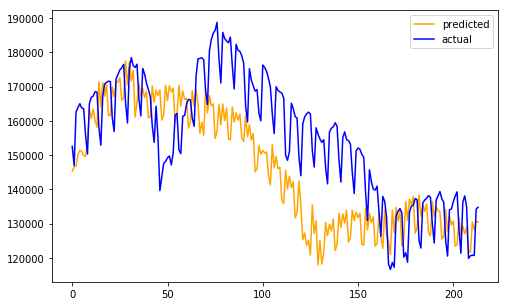

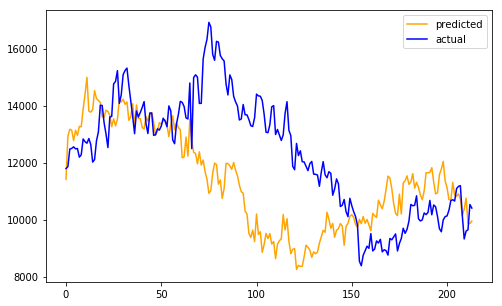

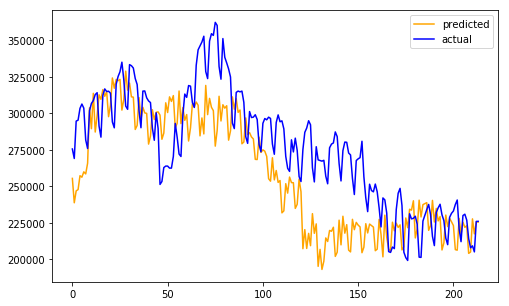

In [97]:
for i in range(len(v_arima_pred)):
    plt.plot(v_arima_pred[i], color="orange")
    plt.plot(v_arima_actual[i], color="blue")
    plt.legend(["predicted", "actual"])
    plt.show()

In [98]:
t_arima_pred = np.array(arima_pred_test(bad_time_series_inds))

Time series 16


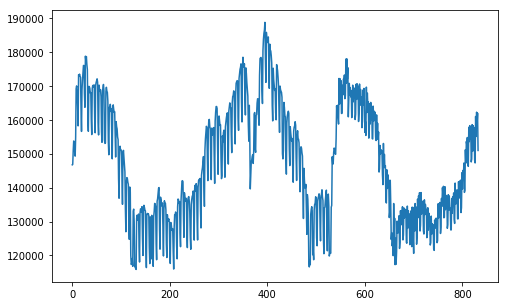

Time series 17


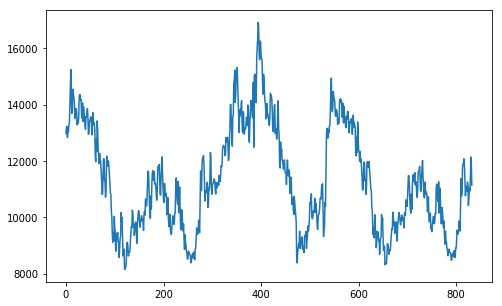

Time series 21


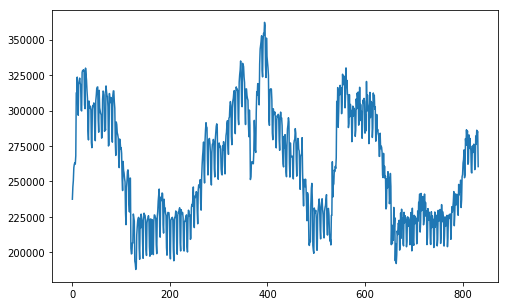

In [99]:
for pred, i in zip(t_arima_pred, bad_time_series_inds):
    print(f"Time series {i}")
    all_data = np.hstack((select_test(i)[0].ACTUAL, pred))    
    plt.plot(all_data)
    plt.show()

In [164]:
t_pred = pd.concat([pred for pred in test(test_data.tsID.unique(), bad_time_series_inds)])

In [165]:
t_pred.shape

(6600, 7)

In [166]:
bad_time_series_inds

array([16, 17, 21])

Time series 16


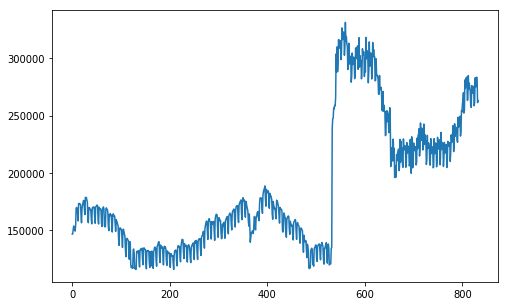

Time series 17


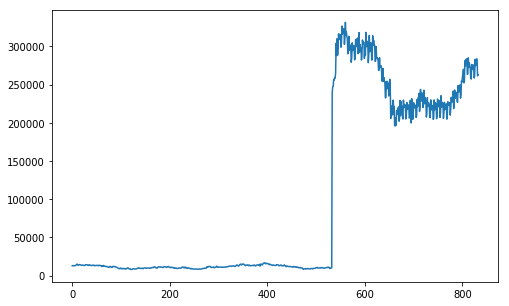

Time series 21


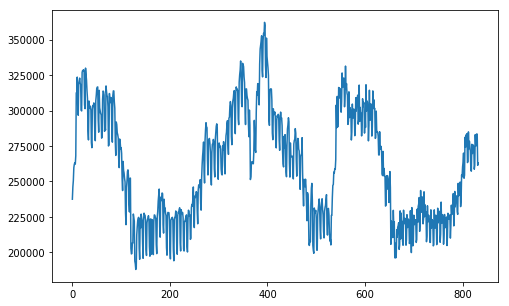

In [167]:
for i in bad_time_series_inds:
    print(f"Time series {i}")
    all_data = np.hstack((select_test(i)[0].ACTUAL, t_pred[t_pred.tsID == i].ACTUAL))    
    plt.plot(all_data)
    plt.show()

In [594]:
t_pred['id'] = t_pred.pop("ID")

In [595]:
funcs.actual_to_csv(t_pred['id'], t_pred.ACTUAL)